The entire code section consist of following number of notebook.

- Synthetic Data Generation
- Dataset Preparation
- __Model UNet__
- integrated Application

## Part-03 : Model UNet

In [1]:
# Run this section only if it is from Colab
# this will mount the gdrive, where all the datasets are saved

inColab = 'google.colab' in str(get_ipython())
if inColab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check if gpu is connected
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Feb 12 15:49:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Declare all the PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Package to handle image
from PIL import Image
import imageio

import os
import glob
import time
import random
import tqdm
# from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

### Utility functions

In [4]:
def plot_metrics(model, title = 'Model Metrics'):
    '''
    Function to plot Dice score, loss and accuracy metrics
    '''
    f, axarr = plt.subplots(1,3, figsize=(15,5))

    # Figure 1
    l = len(model.total_train_f1)
    axarr[0].plot(list(range(l+1))[:l], model.total_train_f1[:l])
    axarr[0].plot(list(range(l+1))[:l], model.total_val_f1[:l])
    axarr[0].legend(['train f1', 'val f1'])
    # axarr[0].set_xlabel('Epochs')
    axarr[0].set_ylabel('Dice Score (f1)')
    axarr[0].set_title('Dice Score')

    # Figure 2
    l = len(model.total_train_losses)
    axarr[1].plot(list(range(l+1))[:l], model.total_train_losses[:l])
    axarr[1].plot(list(range(l+1))[:l], model.total_val_losses[:l])
    axarr[1].legend(['train loss', 'val loss'])
    # axarr[1].set_xlabel('Epochs')
    axarr[1].set_ylabel('Loss')
    axarr[1].set_title('Loss')

    # Figure 3
    l = len(model.total_train_accuracy)
    axarr[2].plot(list(range(l+1))[:l], model.total_train_accuracy[:l])
    axarr[2].plot(list(range(l+1))[:l], model.total_val_accuracy[:l])
    axarr[2].legend(['train acc', 'val acc'])
    # axarr[2].set_xlabel('Epochs')
    axarr[2].set_ylabel('Accuracy')
    axarr[2].set_title('Accuracy')


    f.suptitle(title, fontsize=16)
    f.supxlabel('Epochs')
    f.tight_layout()

    plt.show()

In [5]:
# Define function for plotting images
def plot_predict(i, img, true_mask, output):
    '''
     img - image tensor [B,3,H,W]
     true_mask - mask tensor [B,H,W]
     output - output of model as [B,25,H,W] tensor
     All three elements must match, index i in img must correstpond to index i in output and true mask
    '''
    row = 1
    col = 2
    # Get preiction from output
    pred_mask  = torch.argmax(output, dim=1)

    # Get one image/mask only from the list, based on passed index 'i'
    img = img[i].cpu()
    pred_mask = pred_mask[i].cpu()
    if true_mask is not None:
        true_mask = true_mask[i].cpu()
        col = 3

    # Plot
    f, axarr = plt.subplots(row,col, figsize=(5*col,5))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    if true_mask is not None:
        axarr[1].imshow(true_mask)  # , cmap='tab20'
        axarr[2].imshow(pred_mask)  # , cmap='tab20'
    else:
        axarr[1].imshow(pred_mask)

    plt.show()

In [6]:
def predict_dataloader(model, loader):
    # Get a batch from data set
    img, mask = next(iter(loader))
    model.model.cpu()
    output = model.model(img)
    return img, mask, output

### Function and Class Definition

In [7]:
# Create a custom Dataset class

# Note : Transformation is done in the previous section
# so here i have not planned for any transform or augmentation
# of image.

class tensorDataset(Dataset):
    '''
    Dataset Class
    Param:
        images: list of strings that specify paths to specific tensors
        masks: same as images but for masks
    '''
    def __init__(self, images:list, masks:list, train:bool):
        self.image_links = images
        self.mask_links  = masks
        self.train = train

    # get the image and mask for selected index
    def __getitem__(self, index):
        # Select a specific image's link
        img_id  = self.image_links[index]
        mask_id = self.mask_links[index]

        # Load the tensor image
        img  = torch.load(img_id)
        mask = torch.load(mask_id)

        # Squeeze mask from (1, H, W) to (H, W)
        # This is because loss function accepts (B, H, W)
        mask = mask.squeeze(0)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        mask = mask.long()

        return img, mask


    def __len__(self):
        return len(self.image_links)

### Variable Initialization

In [8]:
# number of class to predict
NUM_CLASSES = 6

# Hyperparameters for deep learning

# size of the input image for training
# 512 x 512 for raw images (dl alone)
# 256 x 256 for roi images (hybrid)

BATCH_SIZE = 10
HEIGHT = 512
WIDTH  = 512

# BATCH_SIZE = 32
# HEIGHT = 256
# WIDTH  = 256

In [9]:
# Specify paths to your files
# (glob stores paths to all files in a folder in a list)

# Specify path for project root folder
# for local system
root = ''
# for colab
if inColab:
    root = '/content/drive/MyDrive/P1_source/'

# directory of training dataset from root of project
sub_dir = 'dataset/sd_2/sd2_raw/'
# sub_dir = 'dataset/sd_2/sd2_roi/'

# Get the list of all train, val image and mask lists
train_img_link_list  = sorted(glob.glob(root + sub_dir + f'/tensor/train_images_{HEIGHT}/*'))
train_mask_link_list = sorted(glob.glob(root + sub_dir + f'/tensor/train_masks_{HEIGHT}/*'))
val_img_link_list    = sorted(glob.glob(root + sub_dir + f'/tensor/val_images_{HEIGHT}/*'))
val_mask_link_list   = sorted(glob.glob(root + sub_dir + f'/tensor/val_masks_{HEIGHT}/*'))

# Train and validation Dataset class object
train_dataset = tensorDataset(train_img_link_list, train_mask_link_list, train=True)
val_dataset   = tensorDataset(val_img_link_list, val_mask_link_list, train=False)

# Train and validation Dataloader class object
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)


### Test the data loader

In [10]:
# Test dataloaders
start = time.time()

# For training dataloader
print('No. of Batch : ',len(train_dataloader))
for i, batch in enumerate(train_dataloader):
    img_batch, img_mask = batch
    print(i, end=' ')
    # print(img_batch.shape)
    # print(img_mask.shape)

# For validation dataloader
print('\nNo. of Batch : ',len(val_dataloader))
for i, batch in enumerate(val_dataloader):
    img_batch, img_mask = batch
    print(i,end=' ')
    # print(img_batch.shape)
    # print(img_mask.shape)

end = time.time()
elapsed = end - start

print('\nTime : ',time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))

No. of Batch :  20
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
No. of Batch :  4
0 1 2 3 
Time :  00h:04m:56s


## U-NET

### Class definition

In [11]:
# U-net is composed of several blocks with pooling in between.
# Each block consists of 2 convolutions,
# therefore to not repeat code at each block we define a class that summarizes it

class DoubleConv(nn.Module):
    '''
    Helper class to perform sequential oepration for each block
    in and out channel need to specified at every block
    '''
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    '''
    Simple U-Net architecture with encoder and decoder like down and up blocks
    '''
    def __init__(self, in_channels=3, out_channels=6, features=[16, 32, 64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs      = nn.ModuleList()
        self.ups        = nn.ModuleList()
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Down part of U-net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        # Bottom layer of U-Net
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Final out put layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Go down the Unet, forwards pass
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Go through the bottleneck
        x = self.bottleneck(x)
        # Reverse the skip connections list ->
        # first are going to be used the ones added last
        skip_connections = skip_connections[::-1]

        # Go up the Unet
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # If original input shape not divisable by 16
            # if x.shape != skip_connection.shape:
                # x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](skip_connection)

        # Last convolution that changes channel output size
        x = self.final_conv(x)
        return x

### Evaluation Metrics

In [13]:
def evaluate_metrics(preds, true_mask):
    '''
    Function for computing Dice Score
    param :
     preds - should be (B, 6, H, W)
     true_mask - should be (B, H, W)
    '''
    f1_batch = []
    accuracy_batch = []
    miou_batch = []

    w, h = preds[0].shape[-2:]

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)

        # Change shape of img from [6, H, W] to [H, W]
        img = torch.argmax(img, dim=0)

        # Compute Accuracy
        accuracy_batch.append(torch.sum(img == mask).item() / (w*h))

        iou_list = list()
        present_iou_list = list()

        # Compute Dice Score
        for label in range(1, NUM_CLASSES):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)

            pred_inds = (img == label)
            target_inds = (mask == label)
            if target_inds.long().sum().item() == 0:
                iou_now = float('nan')
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = float(intersection_now) / float(union_now)
                present_iou_list.append(iou_now)
            iou_list.append(iou_now)

        miou_batch.append(np.mean(present_iou_list))
        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))

    return np.mean(f1_batch), np.mean(accuracy_batch), np.mean(miou_batch)

def f1_dice_score(preds, true_mask):
    '''
    Function for computing Dice Score
    param :
     preds - should be (B, 6, H, W)
     true_mask - should be (B, H, W)
    '''
    f1_batch = []

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)

        # Change shape of img from [6, H, W] to [H, W]
        img = torch.argmax(img, dim=0)

        for label in range(1, NUM_CLASSES):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)

        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))
    return np.mean(f1_batch)


def accuracy(preds, true_mask):
    '''
    Function for computing accuracy
    param :
      preds - should be (B, 6, H, W)
      true_mask -  should be (B, H, W)
    '''
    accuracy_batch = []

    for i in range(len(preds)):
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        w, h = img[0].shape[-2:]

        # Change shape of img from [6, H, W] to [H, W]
        img  = torch.argmax(img, dim=0)

        accuracy_batch.append(torch.sum(img == mask).item() / (w*h))

    return np.mean(accuracy_batch)

## Train function

In [14]:
# save_path = root + sub_dir + 'models/'
save_path = '/content/models/'


class Training:

    def __init__(self, model, loss_fn, optimizer, size=(256,256)):
        self.model = model
        self.criterion = loss_fn
        self.optimizer = optimizer
        self.height, self.width = size

        self.total_train_losses   = []
        self.total_train_accuracy = []
        self.total_train_f1       = []
        self.total_train_miou     = []

        self.total_val_losses     = []
        self.total_val_accuracy   = []
        self.total_val_f1         = []
        self.total_val_miou       = []

        self.time = []

    def train_fn(self, loader):
        # Train model
        self.model.train()
        train_losses   = []
        train_accuracy = []
        train_f1       = []
        train_miou     = []

        for i, batch in enumerate(loader):
            #Extract data, labels
            img_batch, mask_batch = batch   #img [B,3,H,W], mask[B,H,W]
            img_batch = img_batch.to(DEVICE)
            mask_batch = mask_batch.to(DEVICE)

            # Train model
            # ------------
            self.optimizer.zero_grad()

            # Forward pass
            # with torch.cuda.amp.autocast():
            output = self.model(img_batch) # output: [B, 6, H, W]
            loss   = self.criterion(output, mask_batch)

            # backward pass
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 6)
            self.optimizer.step()

            # Compute metrics
            # Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            # f1 = f1_dice_score(output, mask_batch)
            # acc = accuracy(output, mask_batch)
            f1, acc, iou = evaluate_metrics(output, mask_batch)
            train_losses.append(loss.item())
            train_accuracy.append(acc)
            train_f1.append(f1)
            train_miou.append(iou)

        return np.mean(train_losses), np.mean(train_accuracy), np.mean(train_f1), np.mean(train_miou)

    def eval_fn(self, loader):
        # Validate model
        self.model.eval()
        val_losses   = []
        val_accuracy = []
        val_f1       = []
        val_miou     = []

        for i, batch in enumerate(loader):
            # Extract data, labels
            img_batch, mask_batch = batch
            img_batch = img_batch.to(DEVICE)
            mask_batch = mask_batch.to(DEVICE)

            # Validate model
            # ---------------
            # forward pass
            with torch.cuda.amp.autocast():
                output = self.model(img_batch)
                loss   = self.criterion(output, mask_batch)

            # Compute metrics
            # Add current loss to temporary list (after 1 epoch take avg of all batch losses)
            # f1 = f1_dice_score(output, mask_batch)
            # acc = accuracy(output, mask_batch)
            f1, acc, iou = evaluate_metrics(output, mask_batch)
            val_losses.append(loss.item())
            val_accuracy.append(acc)
            val_f1.append(f1)
            val_miou.append(iou)

        return np.mean(val_losses), np.mean(val_accuracy), np.mean(val_f1), np.mean(val_miou)

    def train(self, train_loader, val_loader, n_epochs=5):

        min_val_f1 = 0.3

        print('+---------+--------------------------------+---------------------------------+')
        print('|         |            Train               |           Validation            |')
        print('+---------+--------------------------------+---------------------------------+')
        print('|  Epoch  |   loss,   acc,   f1,    mIoU   |   loss,   acc,   f1,     mIoU   |')
        print('+---------+--------------------------------+---------------------------------+')
        n_epochs = STARTING_EPOCH+EPOCHS

        start = time.time()

        for epoch in range(STARTING_EPOCH+1, STARTING_EPOCH+EPOCHS+1):

            # Train the model
            t_loss, t_acc, t_f1, t_iou = self.train_fn(train_loader)
            print(f'|{epoch:4}/{n_epochs:3} | {t_loss:.4f}, {t_acc:.4f}, {t_f1:.4f}, {t_iou:.4f} |', end= ' ')

            # Validate the model
            v_loss, v_acc, v_f1, v_iou = self.eval_fn(val_loader)
            print(f'{v_loss:.4f}, {v_acc:.4f}, {v_f1:.4f}, {v_iou:.4f} |')

            end = time.time()
            elapsed = end - start
            start = end

            # Store the metrics
            self.total_train_losses.append(t_loss)
            self.total_train_accuracy.append(t_acc)
            self.total_train_f1.append(t_f1)
            self.total_train_miou.append(t_iou)
            self.total_val_losses.append(v_loss)
            self.total_val_accuracy.append(v_acc)
            self.total_val_f1.append(v_f1)
            self.total_val_miou.append(v_iou)
            self.time.append(elapsed)

            # Save the model
            if v_f1 > min_val_f1:
                torch.save(self.model.state_dict(), save_path + f'unet_{epoch}.pt')
                min_val_f1 = v_f1

            # Save the metric results so far
            temp_df = pd.DataFrame(list(zip(self.total_train_losses,
                                            self.total_val_losses,
                                            self.total_train_f1,
                                            self.total_val_f1,
                                            self.total_train_accuracy,
                                            self.total_val_accuracy,
                                           self.total_train_miou,
                                           self.total_val_miou,
                                           self.time)),
                                columns = ['train_loss', 'val_loss',
                                           'train_f1', 'val_f1',
                                           'train_accuracy','val_accuracy',
                                          'train_mIoU','val_mIoU', 'time'])
            temp_df.to_csv(save_path + 'train_val_measures.csv')

        return

    def load_model(self, path, mod_file, met_file = None ):
        ret = self.model.load_state_dict(torch.load(path+mod_file))
        print(ret)
        if met_file is not None:
            df_metrics = pd.read_csv(path+met_file)
            self.total_train_losses = df_metrics.iloc[:,1].values
            self.total_val_losses = df_metrics.iloc[:,2].values
            self.total_train_f1 = df_metrics.iloc[:,3].values
            self.total_val_f1 = df_metrics.iloc[:,4].values
            self.total_train_accuracy = df_metrics.iloc[:,5].values
            self.total_val_accuracy = df_metrics.iloc[:,6].values
            self.total_train_miou = df_metrics.iloc[:7].values
            self.total_val_miou = df_metrics.iloc[:8].values
        return




### DL Training for (For Hybrid model)

In [15]:
# Initialization
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('Training on : ', DEVICE)

Training on :  cuda


In [16]:
# Hyperparameters for training
STARTING_EPOCH = 0
EPOCHS = 200
LR = 0.0001 #0.000001

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


# Define the network
model = UNet(in_channels=3,
             out_channels=NUM_CLASSES,
             features=[32, 64, 128, 256]).to(DEVICE)


# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Define loss function
criterion = nn.CrossEntropyLoss().to(DEVICE)

M2 = Training(model, criterion, optimizer)

> Train the model

In [17]:
M2.train(train_dataloader, val_dataloader)

+---------+--------------------------------+---------------------------------+
|         |            Train               |           Validation            |
+---------+--------------------------------+---------------------------------+
|  Epoch  |   loss,   acc,   f1,    mIoU   |   loss,   acc,   f1,     mIoU   |
+---------+--------------------------------+---------------------------------+
|   1/200 | 1.5177, 0.6635, 0.1299, 0.0975 | 1.6853, 0.2993, 0.0233, 0.0133 |
|   2/200 | 1.2310, 0.9204, 0.1964, 0.1687 | 1.3109, 0.8714, 0.1235, 0.0886 |
|   3/200 | 1.0500, 0.9680, 0.2231, 0.1934 | 1.0264, 0.9662, 0.2082, 0.1843 |
|   4/200 | 0.9695, 0.9729, 0.2382, 0.2034 | 0.9479, 0.9666, 0.2379, 0.1989 |
|   5/200 | 0.9135, 0.9774, 0.2644, 0.2235 | 0.9043, 0.9772, 0.2652, 0.2236 |
|   6/200 | 0.8724, 0.9793, 0.2869, 0.2411 | 0.8463, 0.9791, 0.2878, 0.2403 |
|   7/200 | 0.8334, 0.9807, 0.3087, 0.2588 | 0.8154, 0.9814, 0.3194, 0.2669 |
|   8/200 | 0.7970, 0.9825, 0.3332, 0.2797 | 0.7769, 0.9829

In [18]:
np.mean(M2.time),np.std(M2.time),np.sum(M2.time)/60

(23.92753376841545, 0.1599740898263266, 79.75844589471816)

> for ROI
(7.188326448202133, 0.11711397607919373, 23.96108816067378)

> for Raw
(23.92753376841545, 0.1599740898263266, 79.75844589471816)

In [19]:
# Push the model weight file and csv to drive

!cp '/content/models/unet_193.pt' '/content/drive/MyDrive/P1_source/weights/'
!cp '/content/models/train_val_measures.csv' '/content/drive/MyDrive/P1_source/weights/'

> Load the model from file

In [20]:
mod_file = 'unet_193.pt'
met_file = 'train_val_measures.csv'

M2.load_model(save_path,mod_file, met_file)


<All keys matched successfully>


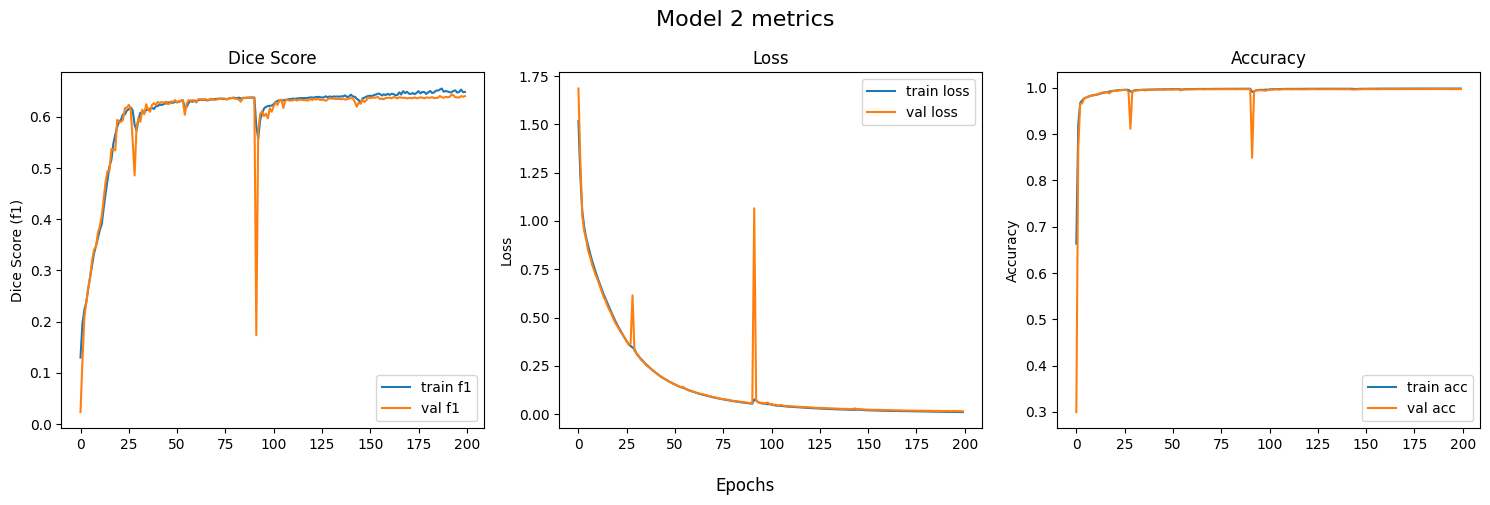

In [21]:
plot_metrics(M2, 'Model 2 metrics')

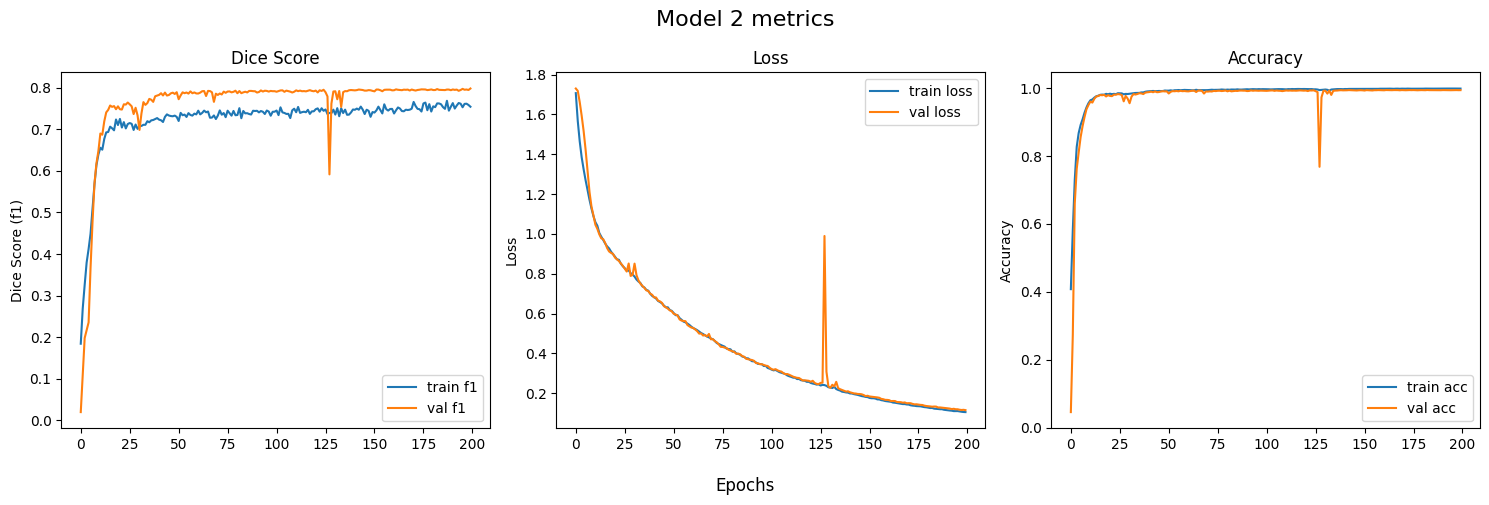

In [ ]:
plot_metrics(M2, 'Model 2 metrics')

### Prediction

In [ ]:
w, h = output[0].shape[-2:]
w,h

(256, 256)

In [25]:
%%time
img, mask, output = predict_dataloader(M2, val_dataloader)

CPU times: user 14.1 s, sys: 8.13 s, total: 22.2 s
Wall time: 23.1 s


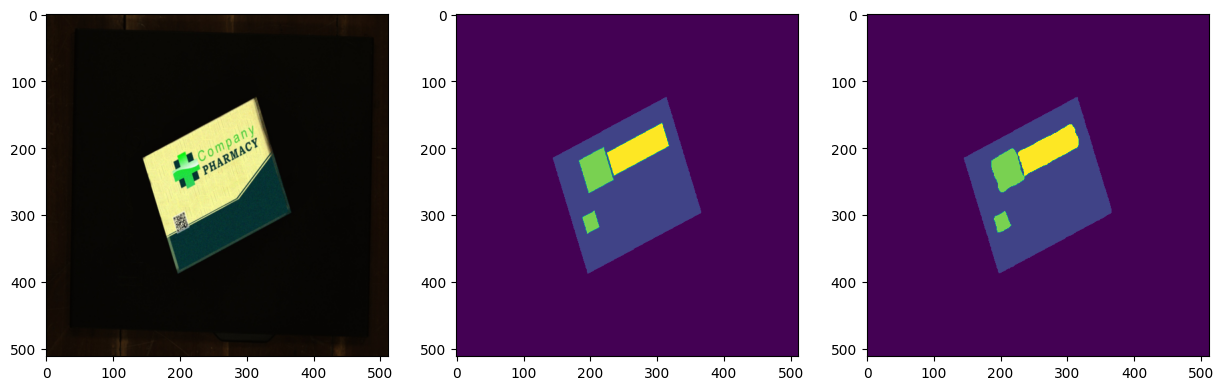

In [32]:
n = random.randint(0,len(img))
plot_predict(n, img, mask, output)

## Load image from file

In [22]:
def predict_fromfile(model, img_path):

    # Transformation pipeline
    transform_img = transforms.Compose([
        transforms.Resize([model.height,model.width]),
        transforms.ToTensor()
    ])

    t_img  = Image.open(img_path)
    t_img  = transform_img(t_img)
    t_img_r = t_img.reshape(1,3,model.height,model.width)
    # print(t_img.shape, t_img_r.shape)

    model.model.cpu()
    output = model.model(t_img_r)

    return t_img_r, output


In [23]:
%%time
# img_path = '/content/drive/MyDrive/P1_source/dataset/td1/td1_roi/train/td1000.jpg'
img_path = '/content/drive/MyDrive/P1_source/dataset/td1/td1_raw/train/td1000.jpg'

# img_path = 'dataset/td1/td1_roi/train/td1000.jpg'

timg, tpred = predict_fromfile(M2, img_path)

CPU times: user 378 ms, sys: 58.1 ms, total: 436 ms
Wall time: 1.18 s


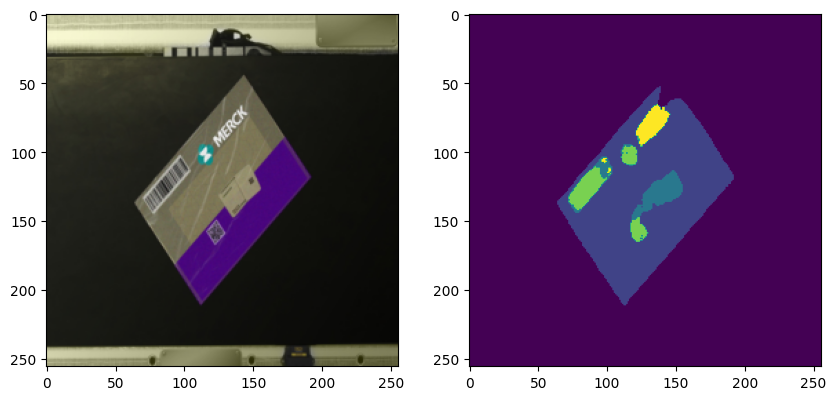

In [24]:
plot_predict(0,timg,None,tpred)

In [ ]:
tpred.shape

torch.Size([1, 6, 256, 256])

## Evaluating using Test dataset